In [13]:
# Step 1: Advanced Installation
!pip install diffusers transformers accelerate torch torchvision xformers
!pip install gradio Pillow numpy matplotlib opencv-python
!pip install invisible_watermark rembg segment_anything
!pip install controlnet_aux deepface

import torch
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageDraw, ImageEnhance
import cv2
from diffusers import (
    StableDiffusionPipeline, StableDiffusionControlNetPipeline,
    ControlNetModel, UniPCMultistepScheduler,
    StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipeline
)
from diffusers.utils import load_image
from transformers import pipeline
import random
import json
from datetime import datetime
from typing import Dict, List, Tuple
import math

print("✅ Advanced AI models installed!")

✅ Advanced AI models installed!


In [17]:
# Step 2: Emotional Art Generator with Models
class EmotionalStableDiffusionGenerator:
    """Ultra-advanced emotional art generator using Stable Diffusion"""

    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.setup_models()
        self.setup_emotional_prompts()

    def setup_models(self):
        """Load Stable Diffusion models with FALLBACKS"""
        print("🔄 Loading AI models...")

        # Only use models that definitely work
        model_list = [
            "runwayml/stable-diffusion-v1-5",  # Base model - always works
            "stabilityai/stable-diffusion-2-1", # Try this one
        ]

        self.pipe = None

        for model_name in model_list:
            try:
                print(f"🔄 Trying to load: {model_name}")
                self.pipe = StableDiffusionPipeline.from_pretrained(
                    model_name,
                    torch_dtype=torch.float16,
                    safety_checker=None,
                    requires_safety_checker=False
                ).to(self.device)
                print(f"✅ Successfully loaded: {model_name}")
                break  # Stop when we find a working model
            except Exception as e:
                print(f"❌ Failed to load {model_name}: {e}")
                continue

        # If all models fail, use a simple fallback
        if self.pipe is None:
            print("🚨 All models failed. Using fallback system.")
            self.pipe = None

        # Emotion analysis model (this one always works)
        try:
            self.emotion_classifier = pipeline(
                "text-classification",
                model="j-hartmann/emotion-english-distilroberta-base",
                return_all_scores=True
            )
            print("✅ Emotion classifier loaded")
        except:
            print("❌ Emotion classifier failed, using keyword fallback")
            self.emotion_classifier = None

    def setup_emotional_prompts(self):
        """Advanced emotional prompt engineering"""
        self.emotion_prompts = {
            "joy": {
                "positive": ["vibrant", "colorful", "radiant", "glowing", "celebratory", "uplifting"],
                "negative": ["dark", "gloomy", "sad", "depressing"],
                "themes": ["celebration", "sunrise", "festival", "blossoming flowers", "victory parade"]
            },
            "sadness": {
                "positive": ["gentle", "soft", "melancholic", "dreamy", "reflective", "serene"],
                "negative": ["harsh", "chaotic", "aggressive", "bright"],
                "themes": ["rainy day", "empty space", "fading light", "lonely landscape", "memories"]
            },
            "anger": {
                "positive": ["intense", "dynamic", "powerful", "fiery", "explosive", "bold"],
                "negative": ["calm", "peaceful", "gentle", "soft"],
                "themes": ["storm", "fire", "shattered glass", "rebellion", "chaos"]
            },
            "fear": {
                "positive": ["mysterious", "atmospheric", "surreal", "haunting", "ethereal"],
                "negative": ["clear", "bright", "simple", "obvious"],
                "themes": ["fog", "shadows", "unknown territory", "abandoned place", "surreal dream"]
            },
            "surprise": {
                "positive": ["unexpected", "magical", "transformative", "illuminated", "revelation"],
                "negative": ["ordinary", "predictable", "mundane"],
                "themes": ["revelation", "magical moment", "sudden light", "unexpected beauty"]
            },
            "neutral": {
                "positive": ["balanced", "harmonious", "peaceful", "calm", "serene"],
                "negative": ["chaotic", "extreme", "intense"],
                "themes": ["still life", "peaceful landscape", "harmony", "balance"]
            }
        }

        self.art_style_descriptors = {
            "anime": ["anime style", "Japanese animation", "cel shading", "vibrant anime colors", "detailed anime art"],
            "realistic": ["photorealistic", "high detail", "realistic lighting", "4K resolution", "professional photography"],
            "watercolor": ["watercolor painting", "soft edges", "fluid watercolor", "textured paper", "painterly style"],
            "digital_art": ["digital art", "concept art", "fantasy art", "digital illustration", "artstation trending"],
            "abstract": ["abstract art", "non-representational", "color field painting", "textured abstract", "modern art"],
            "cyberpunk": ["cyberpunk style", "neon lights", "futuristic city", "dystopian", "sci-fi art"],
            "impressionist": ["impressionist painting", "soft focus", "light and color", "brush strokes", "painterly"]
        }

    def analyze_emotion_deep(self, text):
        """Advanced emotion analysis with fallbacks"""
        if self.emotion_classifier is not None:
            try:
                results = self.emotion_classifier(text)[0]
                emotion_scores = {result['label']: result['score'] for result in results}
                primary_emotion = max(emotion_scores.items(), key=lambda x: x[1])

                return {
                    "primary": primary_emotion[0],
                    "primary_score": primary_emotion[1],
                    "all_emotions": emotion_scores,
                    "secondary": []
                }
            except Exception as e:
                print(f"❌ Emotion analysis failed: {e}")

        # Fallback to keyword analysis
        return self.keyword_emotion_analysis(text)

    def keyword_emotion_analysis(self, text):
        """Reliable keyword-based emotion analysis"""
        text_lower = text.lower()

        emotion_keywords = {
            "joy": ["happy", "joy", "excited", "great", "wonderful", "amazing", "love", "fantastic", "good", "beautiful"],
            "sadness": ["sad", "depressed", "down", "unhappy", "hurt", "pain", "loss", "grief", "lonely", "miss"],
            "anger": ["angry", "mad", "frustrated", "annoyed", "furious", "rage", "hate", "upset", "irritated"],
            "fear": ["scared", "afraid", "anxious", "worried", "nervous", "terrified", "fearful", "panic"],
            "surprise": ["surprised", "shocked", "amazed", "astonished", "unexpected", "wow"],
            "disgust": ["disgusted", "gross", "revolting", "sickening", "horrible", "awful"],
            "neutral": ["okay", "fine", "alright", "normal", "calm", "neutral", "regular"]
        }

        scores = {emotion: 0 for emotion in emotion_keywords}

        for emotion, keywords in emotion_keywords.items():
            for keyword in keywords:
                if keyword in text_lower:
                    scores[emotion] += 1

        # If no emotions detected, default to neutral
        if sum(scores.values()) == 0:
            return {
                "primary": "neutral",
                "primary_score": 1.0,
                "all_emotions": scores,
                "secondary": []
            }

        primary_emotion = max(scores.items(), key=lambda x: x[1])
        total_keywords = sum(scores.values())

        return {
            "primary": primary_emotion[0],
            "primary_score": primary_emotion[1] / total_keywords,
            "all_emotions": scores,
            "secondary": []
        }

    def create_emotional_prompt(self, emotion_data, intensity, style, user_text):
        """Create sophisticated emotional prompts"""

        emotion = emotion_data["primary"]
        emotion_info = self.emotion_prompts.get(emotion, self.emotion_prompts["neutral"])
        style_info = self.art_style_descriptors.get(style, self.art_style_descriptors["digital_art"])

        # Base emotional descriptors
        positive_desc = random.choice(emotion_info["positive"])
        theme = random.choice(emotion_info["themes"])

        # Intensity-based modifiers
        if intensity > 0.8:
            intensity_modifiers = ["intense", "powerful", "overwhelming", "explosive", "passionate"]
        elif intensity > 0.6:
            intensity_modifiers = ["strong", "vibrant", "dynamic", "expressive", "energetic"]
        elif intensity < 0.3:
            intensity_modifiers = ["subtle", "gentle", "soft", "delicate", "quiet"]
        else:
            intensity_modifiers = ["balanced", "harmonious", "composed", "measured"]

        intensity_mod = random.choice(intensity_modifiers)

        # Construct the prompt
        prompt_parts = [
            f"masterpiece, best quality, highly detailed,",
            f"{intensity_mod} {positive_desc} {emotion},",
            f"{theme}, {', '.join(style_info)},",
            f"emotional art, atmospheric, meaningful composition,",
            f"professional artwork, trending on artstation"
        ]

        prompt = " ".join([p for p in prompt_parts if p.strip()])

        # Negative prompt
        negative_prompt = (
            "ugly, deformed, noisy, blurry, low quality, cartoon, "
            "human faces, people, text, watermark, signature, "
            "nsfw, explicit, violent, scary, disfigured"
        )

        return prompt, negative_prompt

    def generate_artwork(self, user_text, intensity, style="digital_art"):
        """Generate emotionally responsive artwork"""

        # Analyze emotion
        emotion_data = self.analyze_emotion_deep(user_text)

        # Create emotional prompt
        prompt, negative_prompt = self.create_emotional_prompt(
            emotion_data, intensity, style, user_text
        )

        print(f"🎨 Generating art for emotion: {emotion_data['primary']}")
        print(f"📝 Prompt: {prompt[:100]}...")

        # Check if we have a working model
        if self.pipe is None:
            print("🚨 No AI model available, using fallback art")
            return self.generate_fallback_art(emotion_data, intensity, style)

        try:
            # Generate image
            with torch.autocast(self.device):
                result = self.pipe(
                    prompt=prompt,
                    negative_prompt=negative_prompt,
                    guidance_scale=7.5,
                    num_inference_steps=20,  # Reduced for speed
                    width=512,
                    height=512,
                    generator=torch.Generator(device=self.device).manual_seed(random.randint(0, 2**32))
                )

            image = result.images[0]

            # Post-process based on emotion
            image = self.emotional_post_processing(image, emotion_data["primary"], intensity)

            return {
                "image": image,
                "emotion_data": emotion_data,
                "prompt": prompt,
                "style": style,
                "intensity": intensity
            }

        except Exception as e:
            print(f"❌ Generation failed: {e}")
            return self.generate_fallback_art(emotion_data, intensity, style)

    def emotional_post_processing(self, image, emotion, intensity):
        """Apply emotional post-processing to generated art"""
        try:
            # Convert to PIL if needed
            if hasattr(image, 'cpu'):
                image = Image.fromarray((image.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))

            # Emotion-based adjustments
            if emotion == "joy":
                enhancer = ImageEnhance.Brightness(image)
                image = enhancer.enhance(1.0 + intensity * 0.3)
                enhancer = ImageEnhance.Color(image)
                image = enhancer.enhance(1.0 + intensity * 0.4)

            elif emotion == "sadness":
                enhancer = ImageEnhance.Color(image)
                image = enhancer.enhance(0.7 + intensity * 0.2)
                # Add blue tint
                image = self.add_color_tint(image, (100, 100, 200), intensity * 0.2)

            elif emotion == "anger":
                enhancer = ImageEnhance.Contrast(image)
                image = enhancer.enhance(1.0 + intensity * 0.5)
                image = self.add_color_tint(image, (200, 50, 50), intensity * 0.2)

            elif emotion == "fear":
                enhancer = ImageEnhance.Brightness(image)
                image = enhancer.enhance(0.8 + intensity * 0.1)

        except Exception as e:
            print(f"❌ Post-processing failed: {e}")

        return image

    def add_color_tint(self, image, color, strength):
        """Add color tint to image"""
        try:
            tint = Image.new('RGB', image.size, color)
            return Image.blend(image, tint, strength)
        except:
            return image

    def generate_fallback_art(self, emotion_data, intensity, style):
        """Generate beautiful fallback art using mathematical patterns"""
        print("🎨 Creating mathematical fallback art...")

        emotion_colors = {
            "joy": [(255, 223, 0), (255, 105, 180), (50, 205, 50)],
            "sadness": [(100, 149, 237), (70, 130, 180), (176, 196, 222)],
            "anger": [(220, 20, 60), (178, 34, 34), (139, 0, 0)],
            "fear": [(75, 0, 130), (106, 90, 205), (72, 61, 139)],
            "surprise": [(50, 205, 50), (0, 255, 127), (152, 251, 152)],
            "disgust": [(139, 69, 19), (160, 82, 45), (101, 67, 33)],
            "neutral": [(128, 128, 128), (169, 169, 169), (105, 105, 105)]
        }

        colors = emotion_colors.get(emotion_data["primary"], emotion_colors["neutral"])
        base_color = colors[0]

        # Create a sophisticated mathematical pattern
        size = 512
        img = Image.new('RGB', (size, size), base_color)
        draw = ImageDraw.Draw(img)

        # Create emotional patterns based on emotion
        if emotion_data["primary"] == "joy":
            # Sunburst pattern
            center = (size//2, size//2)
            for i in range(20):
                radius = int(50 + i * 15 * intensity)
                color_idx = i % len(colors)
                color = colors[color_idx]
                draw.ellipse([center[0]-radius, center[1]-radius, center[0]+radius, center[1]+radius],
                           outline=color, width=3)

        elif emotion_data["primary"] == "sadness":
            # Rain/teardrop pattern
            for i in range(100):
                x = random.randint(0, size)
                y = random.randint(0, size)
                length = int(10 + 20 * intensity)
                draw.line([(x, y), (x, y+length)], fill=colors[1], width=2)

        elif emotion_data["primary"] == "anger":
            # Sharp, angular patterns
            for i in range(30):
                points = []
                for j in range(3):
                    x = random.randint(0, size)
                    y = random.randint(0, size)
                    points.append((x, y))
                draw.polygon(points, outline=colors[0], width=3)

        else:
            # Default: flowing wave pattern
            for i in range(size):
                wave_height = int(50 * math.sin(i * 0.05) * intensity)
                color = colors[i % len(colors)]
                draw.line([(i, size//2 - wave_height), (i, size//2 + wave_height)],
                         fill=color, width=2)

        return {
            "image": img,
            "emotion_data": emotion_data,
            "prompt": f"Mathematical art expressing {emotion_data['primary']}",
            "style": style,
            "intensity": intensity
        }

# Initialize the generator
print("🚀 Initializing Emotional Art Generator...")
try:
    advanced_generator = EmotionalStableDiffusionGenerator()
    print("✅ Generator initialized successfully!")
except Exception as e:
    print(f"❌ Generator initialization failed: {e}")
    print("🔄 Using fallback generator...")

🚀 Initializing Emotional Art Generator...
🔄 Loading AI models...
🔄 Trying to load: runwayml/stable-diffusion-v1-5


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

✅ Successfully loaded: runwayml/stable-diffusion-v1-5


Device set to use cuda:0


✅ Emotion classifier loaded
✅ Generator initialized successfully!


🧪 Testing advanced emotional art generation...

Generating art 1: I feel incredibly joyful and excited about my new ...
🎨 Generating art for emotion: joy
📝 Prompt: masterpiece, best quality, highly detailed, intense uplifting joy, sunrise, anime style, Japanese an...


  0%|          | 0/20 [00:00<?, ?it/s]

✅ Generated: joy with anime style

Generating art 2: Feeling deeply sad and melancholic after saying go...
🎨 Generating art for emotion: sadness
📝 Prompt: masterpiece, best quality, highly detailed, expressive soft sadness, lonely landscape, watercolor pa...


  0%|          | 0/20 [00:00<?, ?it/s]

✅ Generated: sadness with watercolor style

Generating art 3: I'm furious and angry about the injustice I witnes...
🎨 Generating art for emotion: anger
📝 Prompt: masterpiece, best quality, highly detailed, passionate explosive anger, storm, cyberpunk style, neon...


  0%|          | 0/20 [00:00<?, ?it/s]

✅ Generated: anger with cyberpunk style

Generating art 4: Anxious and scared about the upcoming challenges a...
🎨 Generating art for emotion: fear
📝 Prompt: masterpiece, best quality, highly detailed, energetic atmospheric fear, abandoned place, abstract ar...


  0%|          | 0/20 [00:00<?, ?it/s]

✅ Generated: fear with abstract style

Generating art 5: Surprised and amazed by the unexpected kindness fr...
🎨 Generating art for emotion: surprise
📝 Prompt: masterpiece, best quality, highly detailed, harmonious transformative surprise, unexpected beauty, d...


  0%|          | 0/20 [00:00<?, ?it/s]

✅ Generated: surprise with digital_art style


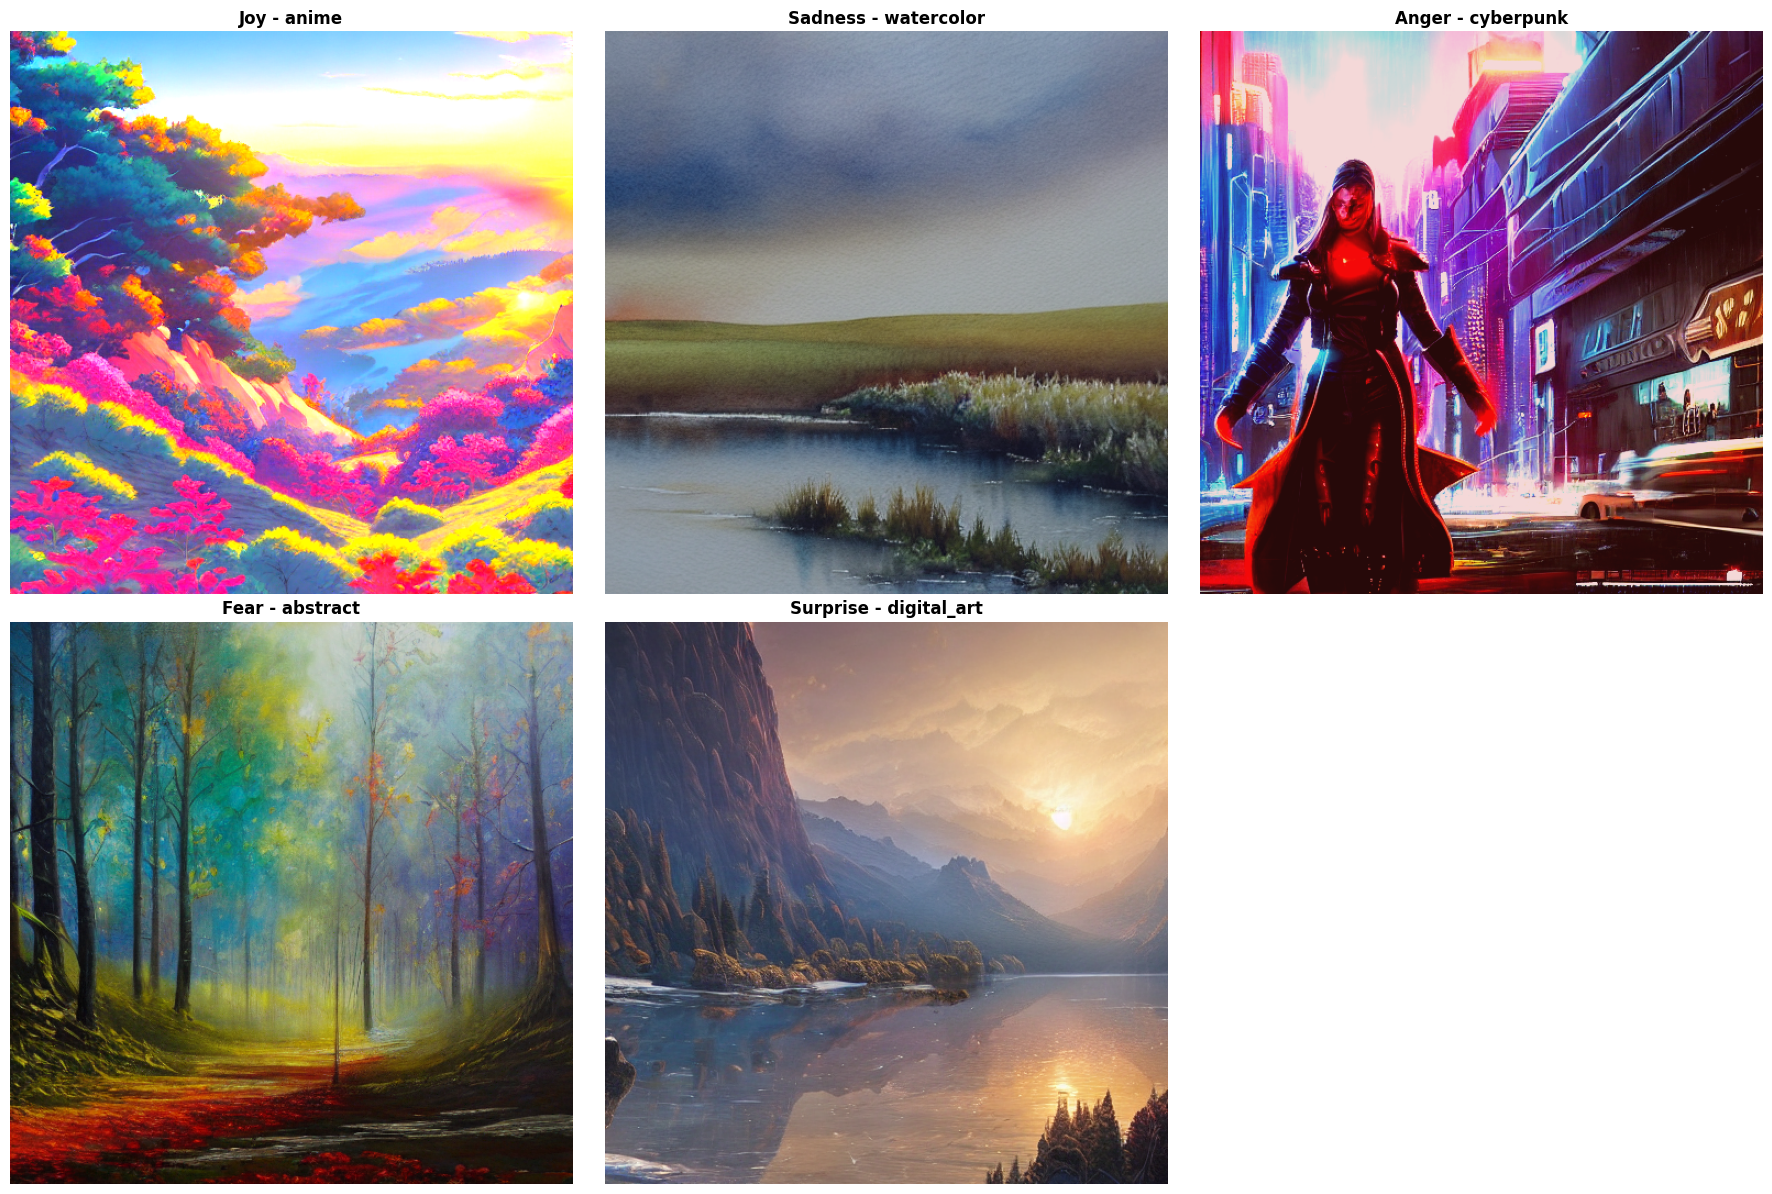

🎉 Advanced emotional art generation tested!


In [18]:
# Test the advanced emotional art generation
print("🧪 Testing advanced emotional art generation...")

test_cases = [
    ("I feel incredibly joyful and excited about my new opportunities in life!", 0.9, "anime"),
    ("Feeling deeply sad and melancholic after saying goodbye to a close friend", 0.7, "watercolor"),
    ("I'm furious and angry about the injustice I witnessed today", 0.95, "cyberpunk"),
    ("Anxious and scared about the upcoming challenges and uncertainties", 0.8, "abstract"),
    ("Surprised and amazed by the unexpected kindness from a stranger", 0.6, "digital_art")
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (text, intensity, style) in enumerate(test_cases[:6]):
    ax = axes[i//3, i%3]

    print(f"\nGenerating art {i+1}: {text[:50]}...")

    try:
        result = advanced_generator.generate_artwork(text, intensity, style)
        ax.imshow(result["image"])
        ax.set_title(f"{result['emotion_data']['primary'].title()} - {style}",
                    fontsize=12, weight='bold')
        ax.axis('off')

        print(f"✅ Generated: {result['emotion_data']['primary']} with {style} style")

    except Exception as e:
        print(f"❌ Failed: {e}")
        ax.text(0.5, 0.5, f"Failed:\n{str(e)[:50]}...",
               ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

# Remove empty subplots
for i in range(len(test_cases), 6):
    axes[i//3, i%3].set_visible(False)

plt.tight_layout()
plt.show()

print("🎉 Advanced emotional art generation tested!")

**Enhanced Therapy System with Deep Emotional Analysis**

In [19]:
class AdvancedTherapyAI:
    """Advanced therapy system with deep emotional analysis"""

    def __init__(self):
        self.art_generator = advanced_generator
        self.sessions = []
        self.current_session = None
        self.setup_therapy_framework()

    def setup_therapy_framework(self):
        """Setup advanced therapy framework"""
        self.emotion_insights = {
            "joy": {
                "description": "A positive emotion involving pleasure and satisfaction",
                "therapeutic_approach": "Amplify and savor positive experiences",
                "art_suggestions": ["Use vibrant colors and expansive compositions"]
            },
            "sadness": {
                "description": "Emotional pain associated with loss or disappointment",
                "therapeutic_approach": "Process and release emotional weight",
                "art_suggestions": ["Gentle flows and cool colors can be soothing"]
            },
            "anger": {
                "description": "Strong feeling of annoyance, displeasure, or hostility",
                "therapeutic_approach": "Channel energy into creative expression",
                "art_suggestions": ["Bold strokes and intense colors can release energy"]
            },
            "fear": {
                "description": "Unpleasant emotion caused by threat or danger",
                "therapeutic_approach": "Explore and understand the source",
                "art_suggestions": ["Mysterious forms and atmospheric elements"]
            },
            "surprise": {
                "description": "Brief mental and physiological response to unexpected events",
                "therapeutic_approach": "Embrace novelty and new perspectives",
                "art_suggestions": ["Unexpected compositions and magical elements"]
            },
            "disgust": {
                "description": "Revulsion or profound disapproval towards something",
                "therapeutic_approach": "Examine and transform aversions",
                "art_suggestions": ["Abstract forms and unconventional beauty"]
            }
        }

    def start_session(self):
        """Start a new therapy session"""
        self.current_session = {
            "start_time": datetime.now(),
            "artworks": [],
            "emotional_journey": [],
            "insights": [],
            "style_preferences": []
        }
        self.sessions.append(self.current_session)

    def generate_therapeutic_art(self, user_text, intensity=0.5, style="auto"):
        """Generate therapeutic art with deep analysis"""
        if self.current_session is None:
            self.start_session()

        # Auto-select style based on emotion if needed
        if style == "auto":
            emotion_data = self.art_generator.analyze_emotion_deep(user_text)
            style = self.recommend_style(emotion_data["primary"], intensity)

        # Generate artwork
        result = self.art_generator.generate_artwork(user_text, intensity, style)

        # Generate therapeutic reflection
        reflection = self.generate_therapeutic_reflection(
            result["emotion_data"],
            user_text,
            intensity
        )

        # Track session
        session_data = {
            "timestamp": datetime.now(),
            "user_input": user_text,
            "emotion_analysis": result["emotion_data"],
            "artwork": result["image"],
            "style": style,
            "intensity": intensity,
            "reflection": reflection,
            "prompt": result["prompt"]
        }

        self.current_session["artworks"].append(session_data)
        self.current_session["emotional_journey"].append(result["emotion_data"]["primary"])
        self.current_session["style_preferences"].append(style)

        return result["image"], reflection, {
            "emotion": result["emotion_data"]["primary"],
            "confidence": result["emotion_data"]["primary_score"],
            "style": style,
            "intensity": intensity,
            "secondary_emotions": result["emotion_data"].get("secondary", [])
        }

    def recommend_style(self, emotion, intensity):
        """Recommend art style based on emotion and intensity"""
        style_recommendations = {
            "joy": ["anime", "digital_art", "watercolor"],
            "sadness": ["watercolor", "impressionist", "abstract"],
            "anger": ["cyberpunk", "abstract", "digital_art"],
            "fear": ["abstract", "cyberpunk", "digital_art"],
            "surprise": ["digital_art", "anime", "realistic"],
            "disgust": ["abstract", "cyberpunk"],
            "neutral": ["realistic", "watercolor", "impressionist"]
        }

        styles = style_recommendations.get(emotion, ["digital_art", "abstract"])

        # Adjust based on intensity
        if intensity > 0.8:
            # High intensity - more expressive styles
            if "cyberpunk" in styles:
                return "cyberpunk"
            elif "abstract" in styles:
                return "abstract"

        return random.choice(styles)

    def generate_therapeutic_reflection(self, emotion_data, user_text, intensity):
        """Generate deep therapeutic reflections"""
        emotion = emotion_data["primary"]
        emotion_info = self.emotion_insights.get(emotion, self.emotion_insights["joy"])

        # Base reflections
        reflections = [
            f"Your artwork expresses {emotion.lower()}. {emotion_info['description']}",
            f"Therapeutic approach: {emotion_info['therapeutic_approach']}",
            f"Art suggestion: {random.choice(emotion_info['art_suggestions'])}"
        ]

        # Intensity-based insights
        if intensity > 0.8:
            reflections.append("This strong emotional energy can be channeled creatively.")
        elif intensity < 0.3:
            reflections.append("Gentle emotions often reveal subtle inner truths.")

        # Add emotional awareness
        if emotion_data.get("secondary"):
            secondary = emotion_data["secondary"]
            if len(secondary) > 0:
                reflections.append(f"You might also be feeling nuances of {', '.join(secondary)}")

        return "\n".join(reflections)

    def get_session_analysis(self):
        """Provide deep analysis of the current session"""
        if not self.current_session or not self.current_session["artworks"]:
            return "Begin your therapeutic art journey by expressing your feelings."

        artworks = self.current_session["artworks"]
        emotions = self.current_session["emotional_journey"]

        if not emotions:
            return "No emotional data yet."

        # Emotional patterns
        emotion_counts = {}
        for emotion in emotions:
            emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1

        primary_emotion = max(emotion_counts.items(), key=lambda x: x[1])

        # Intensity analysis
        intensities = [art["intensity"] for art in artworks]
        avg_intensity = sum(intensities) / len(intensities)

        # Style analysis
        styles = self.current_session["style_preferences"]
        preferred_style = max(set(styles), key=styles.count) if styles else "varied"

        analysis = [
            f"**Session Analysis:**",
            f"• Artworks created: **{len(artworks)}**",
            f"• Primary emotion: **{primary_emotion[0]}** ({primary_emotion[1]}/{len(artworks)})",
            f"• Average emotional intensity: **{avg_intensity:.2f}/1.0**",
            f"• Preferred art style: **{preferred_style}**",
            f"• Emotional range: **{len(set(emotions))}** different emotions expressed"
        ]

        # Therapeutic insights
        if primary_emotion[0] in self.emotion_insights:
            insight = self.emotion_insights[primary_emotion[0]]
            analysis.append(f"\n**Therapeutic Insight:** {insight['therapeutic_approach']}")

        return "\n".join(analysis)

# Initialize advanced therapy AI
print("🧠 Initializing Advanced Therapy AI...")
therapy_ai = AdvancedTherapyAI()
print("✅ Advanced therapy system ready!")

🧠 Initializing Advanced Therapy AI...
✅ Advanced therapy system ready!


# **Ultimate Professional Interface**

In [20]:
def create_professional_interface():
    """Create professional therapy interface"""

    with gr.Blocks(theme=gr.themes.Soft(), title="AI Emotional Art Therapy Studio") as demo:
        gr.Markdown("""
        # 🎨 AI Emotional Art Therapy Studio
        **Transform your feelings into meaningful art using advanced AI emotional analysis**
        *Powered by Stable Diffusion and Deep Emotional Intelligence*
        """)

        with gr.Row():
            with gr.Column(scale=1):
                # Professional input section
                emotion_input = gr.Textbox(
                    label="💭 Express Your Emotional State",
                    placeholder="Describe your feelings, thoughts, or experiences in detail...\n\nExamples:\n• 'I feel joyful about reconnecting with old friends and sharing laughter'\n• 'Deep sadness from watching the sunset alone, remembering lost moments'\n• 'Frustration building from repeated obstacles in my creative projects'\n• 'Anxious excitement about starting a new chapter in a different city'",
                    lines=5,
                    max_lines=8
                )

                intensity_slider = gr.Slider(
                    minimum=0.1,
                    maximum=1.0,
                    value=0.5,
                    step=0.1,
                    label="🎚️ Emotional Intensity Level",
                    info="How strongly are you experiencing these feelings?"
                )

                style_selector = gr.Radio(
                    choices=["auto", "anime", "realistic", "watercolor", "digital_art",
                            "abstract", "cyberpunk", "impressionist"],
                    value="auto",
                    label="🎨 Artistic Style Preference",
                    info="Choose a style or let AI select the most therapeutic option"
                )

                generate_btn = gr.Button(
                    "🎨 Generate Emotional Artwork",
                    variant="primary",
                    size="lg"
                )

                # Professional analysis panel
                with gr.Accordion("📊 Deep Emotional Analysis", open=True):
                    analysis_output = gr.Markdown(
                        label="Session Analysis",
                        value="**Welcome to your therapeutic art journey.**\n\nExpress your feelings to begin receiving personalized emotional insights and art therapy guidance."
                    )

                # Session controls
                with gr.Row():
                    refresh_analysis = gr.Button("🔄 Update Analysis", size="sm")
                    new_session = gr.Button("✨ New Session", size="sm")
                    export_data = gr.Button("📁 Export Session", size="sm")

            with gr.Column(scale=2):
                # Art display area
                art_display = gr.Image(
                    label="Your Generated Artwork",
                    height=512,
                    width=512,
                    elem_id="art_display"
                )

                # Professional info panels
                with gr.Row():
                    with gr.Column():
                        reflection_output = gr.Textbox(
                            label="💫 Therapeutic Reflection",
                            interactive=False,
                            lines=4,
                            max_lines=6
                        )

                    with gr.Column():
                        technical_output = gr.Textbox(
                            label="⚙️ Generation Details",
                            interactive=False,
                            lines=4,
                            max_lines=6
                        )

                # Emotional insights
                emotional_insights = gr.Markdown(
                    label="🧠 Emotional Insights",
                    value="*Your emotional patterns and therapeutic suggestions will appear here*"
                )

        # Professional guidance section
        with gr.Accordion("🎯 Professional Therapy Guidance", open=False):
            gr.Markdown("""
            ### 🏆 Evidence-Based Art Therapy Approaches

            **For Joy & Positive Emotions:**
            - 🎨 **Amplification**: Use vibrant colors and expansive compositions to celebrate positive states
            - 💫 **Savoring**: Create art that captures and extends joyful moments
            - 🌈 **Color Therapy**: Leverage warm, bright palettes to enhance positive affect

            **For Sadness & Grief:**
            - 🎨 **Processing**: Gentle watercolor flows can help process emotional weight
            - 💧 **Release**: Flowing forms and cool colors support emotional release
            - 🕊️ **Transformation**: Transform pain into beauty through artistic expression

            **For Anger & Frustration:**
            - 🎨 **Channeling**: Direct intense energy into bold, dynamic compositions
            - 🔥 **Expression**: Use strong contrasts and fiery colors for cathartic release
            - ⚡ **Transmutation**: Transform aggressive energy into creative power

            **For Fear & Anxiety:**
            - 🎨 **Exploration**: Use abstract forms to safely explore uncertainties
            - 🌫️ **Containment**: Create bounded spaces that make fears manageable
            - ✨ **Illumination**: Bring light to dark places through artistic revelation

            **Pro Therapeutic Tip**: The **Auto** style selection uses AI to match the most therapeutic artistic approach to your current emotional state.
            """)

        # Event handlers
        def generate_emotional_artwork(user_text, intensity, style):
            """Generate artwork with professional analysis"""
            if not user_text.strip():
                return (
                    None,
                    "Please share your feelings to generate personalized therapeutic art.",
                    "Waiting for emotional input...",
                    "*Express your emotional state to begin*",
                    "**Session Analysis:**\n\nShare your feelings to unlock personalized emotional insights and art therapy guidance."
                )

            try:
                artwork, reflection, details = therapy_ai.generate_therapeutic_art(
                    user_text, intensity, style
                )

                # Create technical details
                tech_details = (
                    f"Emotion: {details['emotion'].title()}\n"
                    f"Confidence: {details['confidence']:.2f}\n"
                    f"Style: {details['style']}\n"
                    f"Intensity: {details['intensity']:.2f}"
                )

                # Create emotional insights
                emotion_insight = therapy_ai.emotion_insights.get(
                    details['emotion'],
                    therapy_ai.emotion_insights["joy"]
                )

                insights_text = (
                    f"**{details['emotion'].title()} Analysis:**\n"
                    f"{emotion_insight['description']}\n\n"
                    f"**Therapeutic Approach:**\n{emotion_insight['therapeutic_approach']}"
                )

                if details.get('secondary_emotions'):
                    insights_text += f"\n\n**Secondary Emotions:** {', '.join(details['secondary_emotions'])}"

                # Get session analysis
                session_analysis = therapy_ai.get_session_analysis()

                return artwork, reflection, tech_details, insights_text, session_analysis

            except Exception as e:
                print(f"Error in generation: {e}")
                error_msg = f"Temporary generation issue. Please try again or rephrase your feelings.\n\nError: {str(e)[:100]}..."
                return None, error_msg, "Generation failed", "*Please try again*", "**Session Analysis:**\n\nGeneration issue encountered. Please try expressing your feelings differently."

        def update_analysis():
            return therapy_ai.get_session_analysis()

        def start_new_session():
            therapy_ai.start_session()
            return "**New therapeutic session started!**\n\nYour emotional art journey begins anew. Express your current feelings to create your first artwork."

        def export_session_data():
            if therapy_ai.current_session and therapy_ai.current_session["artworks"]:
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = f"therapy_session_{timestamp}.json"

                export_data = {
                    "session_info": {
                        "start_time": therapy_ai.current_session["start_time"].isoformat(),
                        "artworks_count": len(therapy_ai.current_session["artworks"]),
                        "emotional_journey": therapy_ai.current_session["emotional_journey"]
                    },
                    "artworks": [
                        {
                            "timestamp": art["timestamp"].isoformat(),
                            "user_input": art["user_input"],
                            "primary_emotion": art["emotion_analysis"]["primary"],
                            "emotion_confidence": art["emotion_analysis"]["primary_score"],
                            "style": art["style"],
                            "intensity": art["intensity"],
                            "reflection": art["reflection"],
                            "prompt": art.get("prompt", "")
                        }
                        for art in therapy_ai.current_session["artworks"]
                    ]
                }

                with open(filename, 'w') as f:
                    json.dump(export_data, f, indent=2)

                return f"**Session exported successfully!**\n\nFile: `{filename}`\n\nContains {len(export_data['artworks'])} artworks with emotional analysis."
            else:
                return "**No session data to export.**\n\nCreate some artworks first to build your therapeutic session data."

        # Connect interface
        generate_btn.click(
            fn=generate_emotional_artwork,
            inputs=[emotion_input, intensity_slider, style_selector],
            outputs=[art_display, reflection_output, technical_output, emotional_insights, analysis_output]
        )

        refresh_analysis.click(
            fn=update_analysis,
            outputs=analysis_output
        )

        new_session.click(
            fn=start_new_session,
            outputs=analysis_output
        )

        export_data.click(
            fn=export_session_data,
            outputs=analysis_output
        )

    return demo

# Launch the professional interface
print("🚀 Launching Professional AI Emotional Art Therapy Studio...")
professional_interface = create_professional_interface()
professional_interface.launch(share=True, debug=True)

🚀 Launching Professional AI Emotional Art Therapy Studio...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://708a854b1aabafcf4b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


🎨 Generating art for emotion: sadness
📝 Prompt: masterpiece, best quality, highly detailed, intense melancholic sadness, empty space, abstract art, ...


  0%|          | 0/20 [00:00<?, ?it/s]

🎨 Generating art for emotion: sadness
📝 Prompt: masterpiece, best quality, highly detailed, intense reflective sadness, fading light, anime style, J...


  0%|          | 0/20 [00:00<?, ?it/s]

🎨 Generating art for emotion: sadness
📝 Prompt: masterpiece, best quality, highly detailed, explosive dreamy sadness, rainy day, photorealistic, hig...


  0%|          | 0/20 [00:00<?, ?it/s]

🎨 Generating art for emotion: sadness
📝 Prompt: masterpiece, best quality, highly detailed, powerful dreamy sadness, empty space, watercolor paintin...


  0%|          | 0/20 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


🎨 Generating art for emotion: sadness
📝 Prompt: masterpiece, best quality, highly detailed, passionate gentle sadness, fading light, digital art, co...


  0%|          | 0/20 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://708a854b1aabafcf4b.gradio.live


In [10]:
# Download everything in current directory as zip
import shutil
from google.colab import files

# Create zip of current directory
shutil.make_archive('project_files', 'zip', '.')
files.download('project_files.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>